# import libraries

In [173]:
import numpy
import xarray
import matplotlib
import matplotlib.pyplot as mp
import datetime
import matplotlib.colors
import scipy.stats
import itertools
import string
import matplotlib.patches
import glob
import matplotlib.gridspec
import scipy.ndimage

import wrf
import netCDF4
import cmocean

import pandas

import matplotlib.ticker
import cartopy.mpl.gridliner #import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import mpl_toolkits
import cartopy
import cartopy.io.shapereader

DEGREE_SIGN = u'\u00B0'
mp.rcParams.update({'mathtext.default': 'regular'})

% matplotlib inline

In [2]:
run_info = 'FMAASO'
skip_time=0

# opening mean fields

## control data

In [3]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/400/ens_mean_wrfout_files'
file_list = sorted(glob.glob(root_dir+'/'+'wrfout*.nc'))
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [4]:
ptot_400 = numpy.load('DATA_ptot_400.npy')
wa_400 = numpy.load('DATA_wa_400.npy')
#ua_400 = numpy.load('DATA_ua_400.npy')
#va_400 = numpy.load('DATA_va_400.npy')
#tk_400 = numpy.load('DATA_tk_400.npy')
#prw_400 = numpy.load('DATA_prw_400.npy')

geopot_400 = numpy.load('DATA_geopot_400.npy')
geopot_stag_400 = numpy.load('DATA_geopot_stag_400.npy')
tk_400 = numpy.load('DATA_tk_400.npy')

In [5]:
cont_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [6]:
time = cont_mfds['Times'].values
xlat = cont_mfds['XLAT'].values[0,:,:]
xlong = cont_mfds['XLONG'].values[0,:,:]
landmask = cont_mfds['LANDMASK'].values[0,:,:]
landmask_midpoints = landmask[1:,1:]

In [7]:
qvapor_400 = cont_mfds['QVAPOR']
u_400 = cont_mfds['U']
v_400 = cont_mfds['V']
w_400 = cont_mfds['W']

In [8]:
rainc_400 = cont_mfds['RAINC']
rainnc_400 = cont_mfds['RAINNC']

## phys data

In [9]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/1000/ens_mean_wrfout_files'
file_list = sorted(glob.glob(root_dir+'/'+'wrfout*.nc'))
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [10]:
ptot_1000 = numpy.load('DATA_ptot_1000.npy')
wa_1000 = numpy.load('DATA_wa_1000.npy')
#ua_1000 = numpy.load('DATA_ua_1000.npy')
#va_1000 = numpy.load('DATA_va_1000.npy')
#tk_1000 = numpy.load('DATA_tk_1000.npy')
#prw_1000 = numpy.load('DATA_prw_1000.npy')

geopot_1000 = numpy.load('DATA_geopot_1000.npy')
geopot_stag_1000 = numpy.load('DATA_geopot_stag_1000.npy')
tk_1000 = numpy.load('DATA_tk_1000.npy')

In [11]:
phys_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [12]:
qvapor_1000 = phys_mfds['QVAPOR']
u_1000 = phys_mfds['U']
v_1000 = phys_mfds['V']
w_1000 = phys_mfds['W']

In [13]:
rainc_1000 = phys_mfds['RAINC']
rainnc_1000 = phys_mfds['RAINNC']

## define dx, dy

In [14]:
dx = 50000. # 50,000 m or 50 km
dy = 50000.

# constants

In [15]:
L_v = 2264705.0 # J/kg
c_p = 1005.7 # J/kgK
g = 9.80665 # m/s2

## get landmask

In [16]:
landmask = cont_mfds['LANDMASK'].sel(Time=0).values

In [17]:
lat_indices = ((xlat<=10)&(xlat>=-5))

# calculate raintot and rain diffs

In [18]:
raintot_accum_1000 = rainnc_1000+rainc_1000

raintot_accum_400 = rainnc_400+rainc_400

raintot_1000 = numpy.diff(raintot_accum_1000, axis=0)
raintot_400 = numpy.diff(raintot_accum_400, axis=0)

In [19]:
raintot_diffs = raintot_1000-raintot_400

raintot_diffs_landmask = numpy.copy(raintot_diffs)
raintot_diffs_landmask[:,landmask==0]=numpy.nan
raintot_diffs_lat_subset = raintot_diffs_landmask[:,lat_indices[:,0],:]
raintot_diffs_latmean = numpy.nanmean(raintot_diffs_lat_subset, axis=1)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [20]:
raintot_diffs_latmean_day1 = numpy.nanmean(raintot_diffs_latmean[:24,:], axis=0)
raintot_diffs_latmean_day2_10 = numpy.nanmean(raintot_diffs_latmean[24:,:], axis=0)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


# calculate w diffs for height-longitude plot

In [21]:
wa_diffs = wa_1000-wa_400

wa_diffs_landmask = numpy.copy(wa_diffs)
wa_diffs_landmask[:,:,landmask==0]=numpy.nan

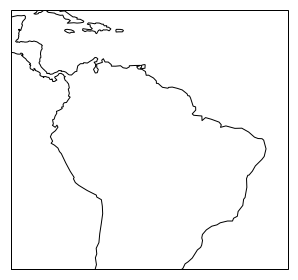

In [22]:
fig, ax = mp.subplots(1,1,subplot_kw={'projection':cartopy.crs.PlateCarree()})
ax.set_extent([270,330,-30,20])
ax.coastlines()
fig.tight_layout()

# calculate MSE

In [23]:
mse_400 = numpy.load('DATA_mse_400.npy')
mse_1000 = numpy.load('DATA_mse_1000.npy')

# calculate midpoints so that fields are 28x178x288

In [24]:
u_400_midpoints = 0.5*(u_400[:,:,:,1:]+u_400[:,:,:,:-1])
u_400_midpoints = 0.5*(u_400_midpoints[:,1:,1:,1:]+u_400_midpoints[:,:-1,:-1,:-1]).values

In [25]:
u_1000_midpoints = 0.5*(u_1000[:,:,:,1:]+u_1000[:,:,:,:-1])
u_1000_midpoints = 0.5*(u_1000_midpoints[:,1:,1:,1:]+u_1000_midpoints[:,:-1,:-1,:-1]).values

In [26]:
v_400_midpoints = 0.5*(v_400[:,:,1:,:]+v_400[:,:,:-1,:])
v_400_midpoints = 0.5*(v_400_midpoints[:,1:,1:,1:]+v_400_midpoints[:,:-1,:-1,:-1]).values

In [27]:
v_1000_midpoints = 0.5*(v_1000[:,:,1:,:]+v_1000[:,:,:-1,:])
v_1000_midpoints = 0.5*(v_1000_midpoints[:,1:,1:,1:]+v_1000_midpoints[:,:-1,:-1,:-1]).values

In [28]:
wa_400_midpoints = (0.5*(wa_400[:,1:,1:,1:]+wa_400[:,:-1,:-1,:-1]))
wa_1000_midpoints = (0.5*(wa_1000[:,1:,1:,1:]+wa_1000[:,:-1,:-1,:-1]))

In [29]:
ptot_400_midpoints = 0.5*(ptot_400[:,1:,1:,1:]+ptot_400[:,:-1,:-1,:-1])
ptot_1000_midpoints = 0.5*(ptot_1000[:,1:,1:,1:]+ptot_1000[:,:-1,:-1,:-1])

In [30]:
geopot_400_midpoints = 0.5*(geopot_400[:,1:,1:,1:]+geopot_400[:,:-1,:-1,:-1])
geopot_1000_midpoints = 0.5*(geopot_1000[:,1:,1:,1:]+geopot_1000[:,:-1,:-1,:-1])

In [31]:
mse_400_midpoints = 0.5*(mse_400[:,1:,1:,1:]+mse_400[:,:-1,:-1,:-1])
mse_1000_midpoints = 0.5*(mse_1000[:,1:,1:,1:]+mse_1000[:,:-1,:-1,:-1])

In [32]:
ptot_1000_midpoints = 0.5*(ptot_1000[:,1:,1:,1:]+ptot_1000[:,:-1,:-1,:-1])
ptot_400_midpoints = 0.5*(ptot_400[:,1:,1:,1:]+ptot_400[:,:-1,:-1,:-1])

# calculate dmsedt terms

In [33]:
ntime = 241
nlev = 28

dmsedt will be automatically placed on midpoints

In [34]:
dmsedt_400 = numpy.zeros((ntime,nlev,xlat.shape[0]-1,xlat.shape[1]-1))*numpy.nan
dmsedt_1000 = numpy.zeros((ntime,nlev,xlat.shape[0]-1,xlat.shape[1]-1))*numpy.nan

In [35]:
for t in range(1,ntime-1):
    dmsedt_400[t,:,:,:] = (mse_400_midpoints[t+1,:,:,:]-mse_400_midpoints[t-1,:,:,:])/7200.
for t in range(1,ntime-1):
    dmsedt_1000[t,:,:,:] = (mse_1000_midpoints[t+1,:,:,:]-mse_1000_midpoints[t-1,:,:,:])/7200.

# calculate convergence terms

In [36]:
dudx_400 = numpy.diff(u_400.values, axis=3)/dx
dudx_400 = 0.5*(dudx_400[:,1:,1:,1:]+dudx_400[:,:-1,:-1,:-1])

In [37]:
dudx_1000 = numpy.diff(u_1000.values, axis=3)/dx
dudx_1000 = 0.5*(dudx_1000[:,1:,1:,1:]+dudx_1000[:,:-1,:-1,:-1])

In [38]:
dvdy_400 = numpy.diff(v_400.values, axis=2)/dy
dvdy_400 = 0.5*(dvdy_400[:,1:,1:,1:]+dvdy_400[:,:-1,:-1,:-1])

In [39]:
dvdy_1000 = numpy.diff(v_1000.values, axis=2)/dy
dvdy_1000 = 0.5*(dvdy_1000[:,1:,1:,1:]+dvdy_1000[:,:-1,:-1,:-1])

In [40]:
ptot_400_diff = numpy.diff(ptot_400, axis=1)
ptot_1000_diff = numpy.diff(ptot_1000, axis=1)

In [41]:
geopot_400_diff = numpy.diff(geopot_400, axis=1) # needed for convergence calculation
geopot_1000_diff = numpy.diff(geopot_1000, axis=1)

In [42]:
geopot_stag_400_diff = numpy.diff(geopot_stag_400, axis=1) # needed for advection calculation
geopot_stag_1000_diff = numpy.diff(geopot_stag_1000, axis=1)

In [43]:
dwdz_400 = numpy.diff(w_400, axis=1)/(geopot_stag_400_diff/g)
dwdz_400 = 0.5*(dwdz_400[:,1:,1:,1:]+dwdz_400[:,:-1,:-1,:-1])

dwdz_1000 = numpy.diff(w_1000, axis=1)/(geopot_stag_1000_diff/g)
dwdz_1000 = 0.5*(dwdz_1000[:,1:,1:,1:]+dwdz_1000[:,:-1,:-1,:-1])

pressure coords

In [44]:
convergence_400 = -mse_400_midpoints*(dudx_400 + dvdy_400 + dwdz_400)
convergence_1000 = -mse_1000_midpoints*(dudx_1000 + dvdy_1000 + dwdz_1000)

calculate vertical and horizontal terms separately

In [45]:
convergence_400_vert = -mse_400_midpoints*dwdz_400 #cont_domegadp
convergence_400_horiz = -mse_400_midpoints*(dudx_400 + dvdy_400)

convergence_1000_vert = -mse_1000_midpoints*dwdz_1000 #phys_domegadp
convergence_1000_horiz = -mse_1000_midpoints*(dudx_1000 + dvdy_1000)

# calculate advection terms

In [48]:
cont_dmsedx = numpy.diff(mse_400, axis=3)/dx # diff in y, then take mean 
cont_dmsedx = 0.5*(cont_dmsedx[:,1:,1:,:]+cont_dmsedx[:,:-1,:-1,:])

In [49]:
phys_dmsedx = numpy.diff(mse_1000, axis=3)/dx # diff in y, then take mean 
phys_dmsedx = 0.5*(phys_dmsedx[:,1:,1:,:]+phys_dmsedx[:,:-1,:-1,:])

In [50]:
cont_dmsedy = numpy.diff(mse_400, axis=2)/dy # diff in y, then take mean 
cont_dmsedy = 0.5*(cont_dmsedy[:,1:,:,1:]+cont_dmsedy[:,:-1,:,:-1])

In [51]:
phys_dmsedy = numpy.diff(mse_1000, axis=2)/dy # diff in y, then take mean 
phys_dmsedy = 0.5*(phys_dmsedy[:,1:,:,1:]+phys_dmsedy[:,:-1,:,:-1])

In [52]:
cont_dmsedz = numpy.diff(mse_400, axis=1)/(geopot_400_diff/g)
cont_dmsedz = 0.5*(cont_dmsedz[:,:,1:,1:]+cont_dmsedz[:,:,:-1,:-1])

In [53]:
phys_dmsedz = numpy.diff(mse_1000, axis=1)/(geopot_1000_diff/g)
phys_dmsedz = 0.5*(phys_dmsedz[:,:,1:,1:]+phys_dmsedz[:,:,:-1,:-1])

In [54]:
advection_400 = -(u_400_midpoints*cont_dmsedx + v_400_midpoints*cont_dmsedy + wa_400_midpoints*cont_dmsedz)
advection_1000 = -(u_1000_midpoints*phys_dmsedx + v_1000_midpoints*phys_dmsedy + wa_1000_midpoints*phys_dmsedz)

for pressure terms

calculate vertical and horizontal terms separately

In [55]:
advection_400_vert = -wa_400_midpoints*cont_dmsedz
advection_400_horiz = -(u_400_midpoints*cont_dmsedx + v_400_midpoints*cont_dmsedy)

advection_1000_vert = -wa_1000_midpoints*phys_dmsedz
advection_1000_horiz = -(u_1000_midpoints*phys_dmsedx + v_1000_midpoints*phys_dmsedy)

# calculate time means

Only time mean for qcloud, qrain, ptot

Rest have day1 mean as well

In [56]:
ptot_400_tm = numpy.nanmean(ptot_400[24:,:,:,:], axis=0)
ptot_1000_tm = numpy.nanmean(ptot_1000[24:,:,:,:], axis=0)

In [57]:
dmsedt_400_tm = numpy.nanmean(dmsedt_400[24:,:,:,:], axis=0)
dmsedt_1000_tm = numpy.nanmean(dmsedt_1000[24:,:,:,:], axis=0)

dmsedt_400_tm_day1 = numpy.nanmean(dmsedt_400[:24,:,:,:], axis=0)
dmsedt_1000_tm_day1 = numpy.nanmean(dmsedt_1000[:24,:,:,:], axis=0)

In [58]:
advection_400_tm = numpy.nanmean(advection_400[24:,:,:,:], axis=0)
advection_1000_tm = numpy.nanmean(advection_1000[24:,:,:,:], axis=0)

advection_400_tm_day1 = numpy.nanmean(advection_400[:24,:,:,:], axis=0)
advection_1000_tm_day1 = numpy.nanmean(advection_1000[:24,:,:,:], axis=0)

In [59]:
convergence_400_tm = numpy.nanmean(convergence_400[24:,:,:,:], axis=0)
convergence_1000_tm = numpy.nanmean(convergence_1000[24:,:,:,:], axis=0)

convergence_400_tm_day1 = numpy.nanmean(convergence_400[:24,:,:,:], axis=0)
convergence_1000_tm_day1 = numpy.nanmean(convergence_1000[:24,:,:,:], axis=0)

In [60]:
convergence_400_tm = numpy.nanmean(convergence_400[24:,:,:,:], axis=0)
convergence_1000_tm = numpy.nanmean(convergence_1000[24:,:,:,:], axis=0)

convergence_400_tm_day1 = numpy.nanmean(convergence_400[:24,:,:,:], axis=0)
convergence_1000_tm_day1 = numpy.nanmean(convergence_1000[:24,:,:,:], axis=0)

calculate vertical and horizontal advection terms

In [61]:
advection_400_vert_tm = numpy.nanmean(advection_400_vert[24:,:,:,:], axis=0)
advection_1000_vert_tm = numpy.nanmean(advection_1000_vert[24:,:,:,:], axis=0)
advection_400_vert_tm_day1 = numpy.nanmean(advection_400_vert[:24,:,:,:], axis=0)
advection_1000_vert_tm_day1 = numpy.nanmean(advection_1000_vert[:24,:,:,:], axis=0)

advection_400_horiz_tm = numpy.nanmean(advection_400_horiz[24:,:,:,:], axis=0)
advection_1000_horiz_tm = numpy.nanmean(advection_1000_horiz[24:,:,:,:], axis=0)
advection_400_horiz_tm_day1 = numpy.nanmean(advection_400_horiz[:24,:,:,:], axis=0)
advection_1000_horiz_tm_day1 = numpy.nanmean(advection_1000_horiz[:24,:,:,:], axis=0)

In [62]:
convergence_400_vert_tm = numpy.nanmean(convergence_400_vert[24:,:,:,:], axis=0)
convergence_1000_vert_tm = numpy.nanmean(convergence_1000_vert[24:,:,:,:], axis=0)
convergence_400_vert_tm_day1 = numpy.nanmean(convergence_400_vert[:24,:,:,:], axis=0)
convergence_1000_vert_tm_day1 = numpy.nanmean(convergence_1000_vert[:24,:,:,:], axis=0)

convergence_400_horiz_tm = numpy.nanmean(convergence_400_horiz[24:,:,:,:], axis=0)
convergence_1000_horiz_tm = numpy.nanmean(convergence_1000_horiz[24:,:,:,:], axis=0)
convergence_400_horiz_tm_day1 = numpy.nanmean(convergence_400_horiz[:24,:,:,:], axis=0)
convergence_1000_horiz_tm_day1 = numpy.nanmean(convergence_1000_horiz[:24,:,:,:], axis=0)

In [63]:
#dry_lon_lo, dry_lon_hi, dry_lat_lo, dry_lat_hi = -60,-50,-10,10
#wet_lon_lo, wet_lon_hi, wet_lat_lo, wet_lat_hi = -80,-75,-10,10

dry_lon_lo, dry_lon_hi, dry_lat_lo, dry_lat_hi = -60,-50,-5,10
wet_lon_lo, wet_lon_hi, wet_lat_lo, wet_lat_hi = -80,-70,-5,10

#dry_lon_lo, dry_lon_hi, dry_lat_lo, dry_lat_hi = -65,-50,-10,10
#wet_lon_lo, wet_lon_hi, wet_lat_lo, wet_lat_hi = -80,-75,-10,10

dry_lon_lo_degE = 360+dry_lon_lo
dry_lon_hi_degE = 360+dry_lon_hi

wet_lon_lo_degE = 360+wet_lon_lo
wet_lon_hi_degE = 360+wet_lon_hi

In [64]:
xlat_midpoints = 0.5*(xlat[1:,1:]+xlat[:-1,:-1])
xlong_midpoints = 0.5*(xlong[1:,1:]+xlong[:-1,:-1])

In [65]:
wet_latlon_subset_midpoints = ((xlat_midpoints<=wet_lat_hi) & (xlat_midpoints>=wet_lat_lo) \
                               & (xlong_midpoints<=wet_lon_hi) & (xlong_midpoints>=wet_lon_lo))

dry_latlon_subset_midpoints = ((xlat_midpoints<=dry_lat_hi) & (xlat_midpoints>=dry_lat_lo) \
                               & (xlong_midpoints<=dry_lon_hi) & (xlong_midpoints>=dry_lon_lo))

lat_indices_midpoints = ((xlat_midpoints<=10)&(xlat_midpoints>=-10))

In [66]:
wet_latlon_subset = ((xlat<=wet_lat_hi) & (xlat>=wet_lat_lo) \
                               & (xlong<=wet_lon_hi) & (xlong>=wet_lon_lo))

dry_latlon_subset = ((xlat<=dry_lat_hi) & (xlat>=dry_lat_lo) \
                               & (xlong<=dry_lon_hi) & (xlong>=dry_lon_lo))

lat_indices = ((xlat<=10)&(xlat>=-10))

# pulling out wet and dry regions

In [67]:
dmsedt_400_wet_region = numpy.nanmean(dmsedt_400_tm[:,wet_latlon_subset_midpoints], axis=1)
dmsedt_400_dry_region = numpy.nanmean(dmsedt_400_tm[:,dry_latlon_subset_midpoints], axis=1)

dmsedt_1000_wet_region = numpy.nanmean(dmsedt_1000_tm[:,wet_latlon_subset_midpoints], axis=1)
dmsedt_1000_dry_region = numpy.nanmean(dmsedt_1000_tm[:,dry_latlon_subset_midpoints], axis=1)

dmsedt_400_wet_region_day1 = numpy.nanmean(dmsedt_400_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
dmsedt_400_dry_region_day1 = numpy.nanmean(dmsedt_400_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

dmsedt_1000_wet_region_day1 = numpy.nanmean(dmsedt_1000_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
dmsedt_1000_dry_region_day1 = numpy.nanmean(dmsedt_1000_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

In [68]:
convergence_400_wet_region = numpy.nanmean(convergence_400_tm[:,wet_latlon_subset_midpoints], axis=1)
convergence_400_dry_region = numpy.nanmean(convergence_400_tm[:,dry_latlon_subset_midpoints], axis=1)

convergence_1000_wet_region = numpy.nanmean(convergence_1000_tm[:,wet_latlon_subset_midpoints], axis=1)
convergence_1000_dry_region = numpy.nanmean(convergence_1000_tm[:,dry_latlon_subset_midpoints], axis=1)

convergence_400_wet_region_day1 = numpy.nanmean(convergence_400_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
convergence_400_dry_region_day1 = numpy.nanmean(convergence_400_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

convergence_1000_wet_region_day1 = numpy.nanmean(convergence_1000_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
convergence_1000_dry_region_day1 = numpy.nanmean(convergence_1000_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

In [181]:
convergence_400.shape

(241, 28, 178, 288)

In [69]:
advection_400_wet_region = numpy.nanmean(advection_400_tm[:,wet_latlon_subset_midpoints], axis=1)
advection_400_dry_region = numpy.nanmean(advection_400_tm[:,dry_latlon_subset_midpoints], axis=1)

advection_1000_wet_region = numpy.nanmean(advection_1000_tm[:,wet_latlon_subset_midpoints], axis=1)
advection_1000_dry_region = numpy.nanmean(advection_1000_tm[:,dry_latlon_subset_midpoints], axis=1)

advection_400_wet_region_day1 = numpy.nanmean(advection_400_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
advection_400_dry_region_day1 = numpy.nanmean(advection_400_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

advection_1000_wet_region_day1 = numpy.nanmean(advection_1000_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
advection_1000_dry_region_day1 = numpy.nanmean(advection_1000_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

In [70]:
wa_400_tm = numpy.nanmean(wa_400[24:,:,:,:], axis=0)
wa_1000_tm = numpy.nanmean(wa_1000[24:,:,:,:], axis=0)

wa_400_tm_day1 = numpy.nanmean(wa_400[:24,:,:,:], axis=0)
wa_1000_tm_day1 = numpy.nanmean(wa_1000[:24,:,:,:], axis=0)

In [71]:
wa_400_wet = numpy.nanmean(wa_400_tm[:,wet_latlon_subset],axis=1)
wa_400_dry = numpy.nanmean(wa_400_tm[:,dry_latlon_subset],axis=1)

wa_1000_wet = numpy.nanmean(wa_1000_tm[:,wet_latlon_subset],axis=1)
wa_1000_dry = numpy.nanmean(wa_1000_tm[:,dry_latlon_subset],axis=1)

wa_400_wet_day1 = numpy.nanmean(wa_400_tm_day1[:,wet_latlon_subset],axis=1)
wa_400_dry_day1 = numpy.nanmean(wa_400_tm_day1[:,dry_latlon_subset],axis=1)

wa_1000_wet_day1 = numpy.nanmean(wa_1000_tm_day1[:,wet_latlon_subset],axis=1)
wa_1000_dry_day1 = numpy.nanmean(wa_1000_tm_day1[:,dry_latlon_subset],axis=1)

In [72]:
convergence_400_vert_wet_region = numpy.nanmean(convergence_400_vert_tm[:,wet_latlon_subset_midpoints], axis=1)
convergence_400_vert_dry_region = numpy.nanmean(convergence_400_vert_tm[:,dry_latlon_subset_midpoints], axis=1)

convergence_1000_vert_wet_region = numpy.nanmean(convergence_1000_vert_tm[:,wet_latlon_subset_midpoints], axis=1)
convergence_1000_vert_dry_region = numpy.nanmean(convergence_1000_vert_tm[:,dry_latlon_subset_midpoints], axis=1)

convergence_400_vert_wet_region_day1 = numpy.nanmean(convergence_400_vert_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
convergence_400_vert_dry_region_day1 = numpy.nanmean(convergence_400_vert_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

convergence_1000_vert_wet_region_day1 = numpy.nanmean(convergence_1000_vert_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
convergence_1000_vert_dry_region_day1 = numpy.nanmean(convergence_1000_vert_tm_day1[:,dry_latlon_subset_midpoints], axis=1)



In [73]:
convergence_400_horiz_wet_region = numpy.nanmean(convergence_400_horiz_tm[:,wet_latlon_subset_midpoints], axis=1)
convergence_400_horiz_dry_region = numpy.nanmean(convergence_400_horiz_tm[:,dry_latlon_subset_midpoints], axis=1)

convergence_1000_horiz_wet_region = numpy.nanmean(convergence_1000_horiz_tm[:,wet_latlon_subset_midpoints], axis=1)
convergence_1000_horiz_dry_region = numpy.nanmean(convergence_1000_horiz_tm[:,dry_latlon_subset_midpoints], axis=1)

convergence_400_horiz_wet_region_day1 = numpy.nanmean(convergence_400_horiz_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
convergence_400_horiz_dry_region_day1 = numpy.nanmean(convergence_400_horiz_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

convergence_1000_horiz_wet_region_day1 = numpy.nanmean(convergence_1000_horiz_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
convergence_1000_horiz_dry_region_day1 = numpy.nanmean(convergence_1000_horiz_tm_day1[:,dry_latlon_subset_midpoints], axis=1)



In [74]:
advection_400_vert_wet_region = numpy.nanmean(advection_400_vert_tm[:,wet_latlon_subset_midpoints], axis=1)
advection_400_vert_dry_region = numpy.nanmean(advection_400_vert_tm[:,dry_latlon_subset_midpoints], axis=1)

advection_1000_vert_wet_region = numpy.nanmean(advection_1000_vert_tm[:,wet_latlon_subset_midpoints], axis=1)
advection_1000_vert_dry_region = numpy.nanmean(advection_1000_vert_tm[:,dry_latlon_subset_midpoints], axis=1)

advection_400_vert_wet_region_day1 = numpy.nanmean(advection_400_vert_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
advection_400_vert_dry_region_day1 = numpy.nanmean(advection_400_vert_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

advection_1000_vert_wet_region_day1 = numpy.nanmean(advection_1000_vert_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
advection_1000_vert_dry_region_day1 = numpy.nanmean(advection_1000_vert_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

In [75]:
advection_400_horiz_wet_region = numpy.nanmean(advection_400_horiz_tm[:,wet_latlon_subset_midpoints], axis=1)
advection_400_horiz_dry_region = numpy.nanmean(advection_400_horiz_tm[:,dry_latlon_subset_midpoints], axis=1)

advection_1000_horiz_wet_region = numpy.nanmean(advection_1000_horiz_tm[:,wet_latlon_subset_midpoints], axis=1)
advection_1000_horiz_dry_region = numpy.nanmean(advection_1000_horiz_tm[:,dry_latlon_subset_midpoints], axis=1)

advection_400_horiz_wet_region_day1 = numpy.nanmean(advection_400_horiz_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
advection_400_horiz_dry_region_day1 = numpy.nanmean(advection_400_horiz_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

advection_1000_horiz_wet_region_day1 = numpy.nanmean(advection_1000_horiz_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
advection_1000_horiz_dry_region_day1 = numpy.nanmean(advection_1000_horiz_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

# plot vertical changes using ptot change

In [76]:
ptot_400_dry_region_midpoints = numpy.nanmean(ptot_400_midpoints[:,:,dry_latlon_subset_midpoints], axis=(0,2))
ptot_400_wet_region_midpoints = numpy.nanmean(ptot_400_midpoints[:,:,wet_latlon_subset_midpoints], axis=(0,2))

In [77]:
ptot_400_dry_region = numpy.nanmean(ptot_400[:,:,dry_latlon_subset], axis=(0,2))
ptot_400_wet_region = numpy.nanmean(ptot_400[:,:,wet_latlon_subset], axis=(0,2))

In [78]:
diff_wet_region_dmsedt = dmsedt_1000_wet_region-dmsedt_400_wet_region
diff_dry_region_dmsedt = dmsedt_1000_dry_region-dmsedt_400_dry_region

diff_wet_region_dmsedt_day1 = dmsedt_1000_wet_region_day1-dmsedt_400_wet_region_day1
diff_dry_region_dmsedt_day1 = dmsedt_1000_dry_region_day1-dmsedt_400_dry_region_day1

In [79]:
diff_wet_region_conv = convergence_1000_wet_region-convergence_400_wet_region
diff_dry_region_conv = convergence_1000_dry_region-convergence_400_dry_region

diff_wet_region_conv_day1 = convergence_1000_wet_region_day1-convergence_400_wet_region_day1
diff_dry_region_conv_day1 = convergence_1000_dry_region_day1-convergence_400_dry_region_day1

In [80]:
diff_wet_region_adv = advection_1000_wet_region-advection_400_wet_region
diff_dry_region_adv = advection_1000_dry_region-advection_400_dry_region

diff_wet_region_adv_day1 = advection_1000_wet_region_day1-advection_400_wet_region_day1
diff_dry_region_adv_day1 = advection_1000_dry_region_day1-advection_400_dry_region_day1

In [81]:
wa_diff_wet_region = wa_1000_wet-wa_400_wet
wa_diff_dry_region = wa_1000_dry-wa_400_dry

wa_diff_wet_region_day1 = wa_1000_wet_day1-wa_400_wet_day1
wa_diff_dry_region_day1 = wa_1000_dry_day1-wa_400_dry_day1

same but for vert and horiz split up

In [82]:
diff_wet_region_vert_conv = convergence_1000_vert_wet_region-convergence_400_vert_wet_region
diff_dry_region_vert_conv = convergence_1000_vert_dry_region-convergence_400_vert_dry_region

diff_wet_region_vert_conv_day1 = convergence_1000_vert_wet_region_day1-convergence_400_vert_wet_region_day1
diff_dry_region_vert_conv_day1 = convergence_1000_vert_dry_region_day1-convergence_400_vert_dry_region_day1

diff_wet_region_vert_adv = advection_1000_vert_wet_region-advection_400_vert_wet_region
diff_dry_region_vert_adv = advection_1000_vert_dry_region-advection_400_vert_dry_region

diff_wet_region_vert_adv_day1 = advection_1000_vert_wet_region_day1-advection_400_vert_wet_region_day1
diff_dry_region_vert_adv_day1 = advection_1000_vert_dry_region_day1-advection_400_vert_dry_region_day1

In [83]:
diff_wet_region_horiz_conv = convergence_1000_horiz_wet_region-convergence_400_horiz_wet_region
diff_dry_region_horiz_conv = convergence_1000_horiz_dry_region-convergence_400_horiz_dry_region

diff_wet_region_horiz_conv_day1 = convergence_1000_horiz_wet_region_day1-convergence_400_horiz_wet_region_day1
diff_dry_region_horiz_conv_day1 = convergence_1000_horiz_dry_region_day1-convergence_400_horiz_dry_region_day1

diff_wet_region_horiz_adv = advection_1000_horiz_wet_region-advection_400_horiz_wet_region
diff_dry_region_horiz_adv = advection_1000_horiz_dry_region-advection_400_horiz_dry_region

diff_wet_region_horiz_adv_day1 = advection_1000_horiz_wet_region_day1-advection_400_horiz_wet_region_day1
diff_dry_region_horiz_adv_day1 = advection_1000_horiz_dry_region_day1-advection_400_horiz_dry_region_day1

# dmsedt time series

In [95]:
ptot_400_dry_latlon = ptot_400_midpoints[:,:,dry_latlon_subset_midpoints]

dmsedt_400_dry_latlon = dmsedt_400[:,:,dry_latlon_subset_midpoints]
dmsedt_1000_dry_latlon = dmsedt_1000[:,:,dry_latlon_subset_midpoints]
dmsedt_diff_dry_latlon = dmsedt_1000_dry_latlon-dmsedt_400_dry_latlon

dmsedt_400_dry_latlon_areamean = numpy.nanmean(dmsedt_400_dry_latlon, axis=2)
dmsedt_diff_dry_latlon_areamean = numpy.nanmean(dmsedt_diff_dry_latlon, axis=2)
ptot_400_dry_latlon_areamean = numpy.nanmean(ptot_400_dry_latlon, axis=2)

In [186]:
convergence_400_dry_latlon = convergence_400[:,:,dry_latlon_subset_midpoints]
convergence_1000_dry_latlon = convergence_1000[:,:,dry_latlon_subset_midpoints]

advection_400_dry_latlon = advection_400[:,:,dry_latlon_subset_midpoints]
advection_1000_dry_latlon = advection_1000[:,:,dry_latlon_subset_midpoints]

advection_diff_dry_latlon = advection_1000_dry_latlon-advection_400_dry_latlon
convergence_diff_dry_latlon = convergence_1000_dry_latlon-convergence_400_dry_latlon

advection_400_dry_latlon_areamean = numpy.nanmean(advection_400_dry_latlon, axis=2)
convergence_400_dry_latlon_areamean = numpy.nanmean(convergence_400_dry_latlon, axis=2)
advection_diff_dry_latlon_areamean = numpy.nanmean(advection_diff_dry_latlon, axis=2)
convergence_diff_dry_latlon_areamean = numpy.nanmean(convergence_diff_dry_latlon, axis=2)

In [108]:
xx_dmsedt, pp_dmsedt = numpy.meshgrid(numpy.arange(241), ptot_400_dry_latlon_areamean[0,:])

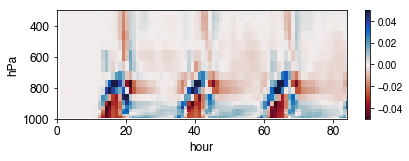

In [129]:
fontsize = 12

fig = mp.figure(figsize=(6.5,2))

ax = fig.add_subplot(111)
ax.tick_params(labelsize=fontsize)
contour_plot = ax.pcolormesh(xx_dmsedt, ptot_400_dry_latlon_areamean.T/100., \
                             dmsedt_diff_dry_latlon_areamean.T, \
                             cmap=cmocean.cm.balance_r, vmin=-.05, vmax=.05)

ax.set_ylim(1000,300)
#ax.set_xlim(0,240)
ax.set_xlim(0,84)

ax.set_xlabel('hour', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)

fig.colorbar(contour_plot)

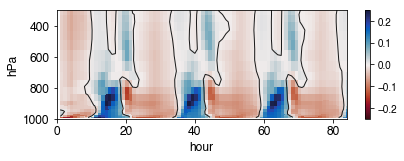

In [130]:
fontsize = 12

fig = mp.figure(figsize=(6.5,2))

ax = fig.add_subplot(111)
ax.tick_params(labelsize=fontsize)
contour_plot = ax.pcolormesh(xx_dmsedt, ptot_400_dry_latlon_areamean.T/100., \
                             dmsedt_400_dry_latlon_areamean.T, \
                             cmap=cmocean.cm.balance_r, vmin=-.25, vmax=.25)

contour_line = ax.contour(xx_dmsedt, ptot_400_dry_latlon_areamean.T/100., \
                          dmsedt_400_dry_latlon_areamean.T, \
                          levels=[0], linewidths=[1], colors='0.1')
ax.set_ylim(1000,300)
ax.set_xlim(0,84)

ax.set_xlabel('hour', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)

fig.colorbar(contour_plot)



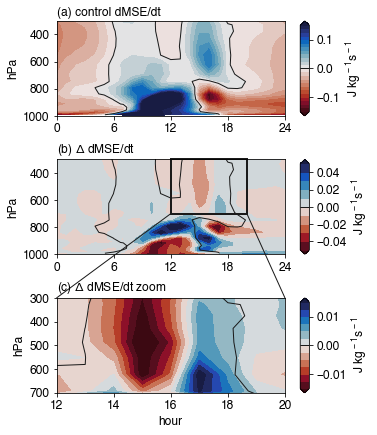

In [177]:
fontsize = 12

fig = mp.figure(figsize=(4.25,6))


ax1 = fig.add_subplot(311)
ax1.tick_params(labelsize=fontsize)
# contour_plot1 = ax1.pcolormesh(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
#                              dmsedt_400_dry_latlon_areamean.T, \
#                              cmap=cmocean.cm.balance_r, vmin=-.2, vmax=.2)

levels = numpy.arange(-.15,.151,0.0125)
contour_plot1 = ax1.contourf(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                             dmsedt_400_dry_latlon_areamean.T, \
                             cmap=cmocean.cm.balance_r, extend='both', levels=levels)

contour_line1 = ax1.contour(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                          dmsedt_400_dry_latlon_areamean.T, \
                          levels=[0], linewidths=[1], colors='0.1')
ax1.set_ylim(1000,300)
ax1.set_xlim(0,24)
ax1.set_xticks([i for i in range(0,25,6)])
ax1.set_yticks([400,600,800,1000])
#ax1.set_xlabel('hour', fontsize=fontsize)
ax1.set_ylabel('hPa', fontsize=fontsize)



ax2 = fig.add_subplot(312)
ax2.tick_params(labelsize=fontsize)
# contour_plot2 = ax2.pcolormesh(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
#                              dmsedt_diff_dry_latlon_areamean.T, \
#                              cmap=cmocean.cm.balance_r, vmin=-.05, vmax=.05)

levels = numpy.arange(-0.05,0.051,0.01)

contour_plot2 = ax2.contourf(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                             dmsedt_diff_dry_latlon_areamean.T, \
                             cmap=cmocean.cm.balance_r, extend='both', levels=levels)

contour_line2 = ax2.contour(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                          dmsedt_400_dry_latlon_areamean.T, \
                          levels=[0], linewidths=[1], colors='0.1')
ax2.set_ylim(1000,300)
#ax.set_xlim(0,240)
ax2.set_xlim(0,24)
#ax2.set_xlabel('hour', fontsize=fontsize)
ax2.set_ylabel('hPa', fontsize=fontsize)
ax2.set_xticks([i for i in range(0,25,6)])
ax2.set_yticks([400,600,800,1000])

ax2.add_patch(matplotlib.patches.Rectangle((12,700),8,-400, \
                                           fill=False, \
                                           edgecolor='0.1', lw=2, clip_on=False))



ax3 = fig.add_subplot(313)
ax3.tick_params(labelsize=fontsize)

levels = numpy.arange(-0.015,0.0151,0.0025)
contour_plot3 = ax3.contourf(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                             dmsedt_diff_dry_latlon_areamean.T, \
                             cmap=cmocean.cm.balance_r, levels=levels, extend='both')
contour_line3 = ax3.contour(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                          dmsedt_400_dry_latlon_areamean.T, \
                          levels=[0], linewidths=[1], colors='0.1')
ax3.set_ylim(700,300)
#ax.set_xlim(0,240)
ax3.set_xlim(12,20)
ax3.set_xlabel('hour', fontsize=fontsize)
ax3.set_ylabel('hPa', fontsize=fontsize)
ax3.set_xticks([i for i in range(12,21,2)])
ax3.set_yticks([300,400,500,600,700])

ax1.text(s='(a) control dMSE/dt', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax1.transAxes)
ax2.text(s='(b) $\Delta$ dMSE/dt', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax2.transAxes)
ax3.text(s='(c) $\Delta$ dMSE/dt zoom', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax3.transAxes)

fig.tight_layout(h_pad=2)

ax1pos = ax1.get_position()
cbar_ax1 = fig.add_axes([ax1pos.x1+0.05, ax1pos.y0, 0.03, ax1pos.height])
cbar1 = fig.colorbar(contour_plot1, cax=cbar_ax1)
cbar_ax1.tick_params(labelsize=fontsize)
cbar1.add_lines(contour_line1)
cbar1.set_label('J kg$^{\,-1}$s$^{\,-1}$', fontsize=fontsize)
cbar1.set_ticks([-.1,0,.1])

ax2pos = ax2.get_position()
cbar_ax2 = fig.add_axes([ax2pos.x1+0.05, ax2pos.y0, 0.03, ax2pos.height])
cbar2 = fig.colorbar(contour_plot2, cax=cbar_ax2)
cbar_ax2.tick_params(labelsize=fontsize)
cbar2.set_label('J kg$^{\,-1}$s$^{\,-1}$', fontsize=fontsize)
cbar2.add_lines(contour_line2)

ax3pos = ax3.get_position()
cbar_ax3 = fig.add_axes([ax3pos.x1+0.05, ax3pos.y0, 0.03, ax3pos.height])
cbar3 = fig.colorbar(contour_plot3, cax=cbar_ax3)
cbar_ax3.tick_params(labelsize=fontsize)
cbar3.add_lines(contour_line3)
cbar3.set_label('J kg$^{\,-1}$s$^{\,-1}$', fontsize=fontsize)
cbar3.set_ticks([-.01,0,.01])

conpatch = matplotlib.patches.ConnectionPatch(xyA=(12,300), \
                                              xyB=(12,700), \
                                              coordsA='data', \
                                              coordsB='data', \
                                              axesA=ax3, \
                                              axesB=ax2, \
                                              color='0.1')
ax3.add_artist(conpatch)

conpatch = matplotlib.patches.ConnectionPatch(xyA=(20,300), \
                                              xyB=(20,700), \
                                              coordsA='data', \
                                              coordsB='data', \
                                              axesA=ax3, \
                                              axesB=ax2, \
                                              color='0.1')

ax3.add_artist(conpatch)

fig.savefig('manuscript_fig9_dmsedt_profile_first_1days.png', dpi=600, bbox_inches='tight', transparent=True)

In [ ]:
#mean_dmsedt_24h = 

ptot_400_dry_latlon_areamean.shape

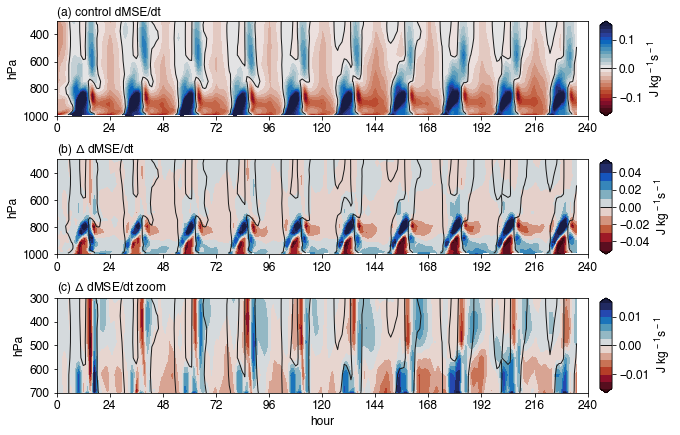

In [197]:
fontsize = 12

fig = mp.figure(figsize=(8.5,6))


ax1 = fig.add_subplot(311)
ax1.tick_params(labelsize=fontsize)
# contour_plot1 = ax1.pcolormesh(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
#                              dmsedt_400_dry_latlon_areamean.T, \
#                              cmap=cmocean.cm.balance_r, vmin=-.2, vmax=.2)

levels = numpy.arange(-.15,.151,0.0125)
contour_plot1 = ax1.contourf(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                             dmsedt_400_dry_latlon_areamean.T, \
                             cmap=cmocean.cm.balance_r, extend='both', levels=levels)

contour_line1 = ax1.contour(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                          dmsedt_400_dry_latlon_areamean.T, \
                          levels=[0], linewidths=[1], colors='0.1')
ax1.set_ylim(1000,300)
ax1.set_xlim(0,240)
ax1.set_xticks([i for i in range(0,241,24)])
ax1.set_yticks([400,600,800,1000])
#ax1.set_xlabel('hour', fontsize=fontsize)
ax1.set_ylabel('hPa', fontsize=fontsize)



ax2 = fig.add_subplot(312)
ax2.tick_params(labelsize=fontsize)
# contour_plot2 = ax2.pcolormesh(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
#                              dmsedt_diff_dry_latlon_areamean.T, \
#                              cmap=cmocean.cm.balance_r, vmin=-.05, vmax=.05)

levels = numpy.arange(-0.05,0.051,0.01)

contour_plot2 = ax2.contourf(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                             dmsedt_diff_dry_latlon_areamean.T, \
                             cmap=cmocean.cm.balance_r, extend='both', levels=levels)

contour_line2 = ax2.contour(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                          dmsedt_400_dry_latlon_areamean.T, \
                          levels=[0], linewidths=[1], colors='0.1')
ax2.set_ylim(1000,300)
#ax.set_xlim(0,240)
ax2.set_xlim(0,240)
#ax2.set_xlabel('hour', fontsize=fontsize)
ax2.set_ylabel('hPa', fontsize=fontsize)
ax2.set_xticks([i for i in range(0,241,24)])
ax2.set_yticks([400,600,800,1000])

# ax2.add_patch(matplotlib.patches.Rectangle((12,600),8,-300, \
#                                            fill=False, \
#                                            edgecolor='0.1', lw=2, clip_on=False))



ax3 = fig.add_subplot(313)
ax3.tick_params(labelsize=fontsize)
# contour_plot3 = ax3.pcolormesh(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
#                              dmsedt_diff_dry_latlon_areamean.T, \
#                              cmap=cmocean.cm.balance_r, vmin=-.05, vmax=.05)

levels = numpy.arange(-0.015,0.0151,0.0025)

contour_plot3 = ax3.contourf(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                             dmsedt_diff_dry_latlon_areamean.T, \
                             cmap=cmocean.cm.balance_r, levels=levels, extend='both')

contour_line3 = ax3.contour(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                          dmsedt_400_dry_latlon_areamean.T, \
                          levels=[0], linewidths=[1], colors='0.1')
ax3.set_ylim(700,300)
#ax.set_xlim(0,240)
ax3.set_xlim(0,240)
ax3.set_xlabel('hour', fontsize=fontsize)
ax3.set_ylabel('hPa', fontsize=fontsize)
ax3.set_xticks([i for i in range(0,241,24)])
ax3.set_yticks([300,400,500,600,700])


ax1.text(s='(a) control dMSE/dt', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax1.transAxes)
ax2.text(s='(b) $\Delta$ dMSE/dt', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax2.transAxes)
ax3.text(s='(c) $\Delta$ dMSE/dt zoom', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax3.transAxes)

fig.tight_layout(h_pad=2)

ax1pos = ax1.get_position()
cbar_ax1 = fig.add_axes([ax1pos.x1+0.02, ax1pos.y0, 0.02, ax1pos.height])
cbar1 = fig.colorbar(contour_plot1, cax=cbar_ax1)
cbar_ax1.tick_params(labelsize=fontsize)
cbar1.add_lines(contour_line1)
cbar1.set_label('J kg$^{\,-1}$s$^{\,-1}$', fontsize=fontsize)
cbar1.set_ticks([-.1,0,.1])

ax2pos = ax2.get_position()
cbar_ax2 = fig.add_axes([ax2pos.x1+0.02, ax2pos.y0, 0.02, ax2pos.height])
cbar2 = fig.colorbar(contour_plot2, cax=cbar_ax2)
cbar_ax2.tick_params(labelsize=fontsize)
cbar2.set_label('J kg$^{\,-1}$s$^{\,-1}$', fontsize=fontsize)
cbar2.add_lines(contour_line2)

ax3pos = ax3.get_position()
cbar_ax3 = fig.add_axes([ax3pos.x1+0.02, ax3pos.y0, 0.02, ax3pos.height])
cbar3 = fig.colorbar(contour_plot3, cax=cbar_ax3)
cbar_ax3.tick_params(labelsize=fontsize)
cbar3.add_lines(contour_line3)
cbar3.set_label('J kg$^{\,-1}$s$^{\,-1}$', fontsize=fontsize)
cbar3.set_ticks([-.01,0,.01])

# conpatch = matplotlib.patches.ConnectionPatch(xyA=(0,300), \
#                                               xyB=(0,600), \
#                                               coordsA='data', \
#                                               coordsB='data', \
#                                               axesA=ax3, \
#                                               axesB=ax2, \
#                                               color='0.1')
# ax3.add_artist(conpatch)

# conpatch = matplotlib.patches.ConnectionPatch(xyA=(120,300), \
#                                               xyB=(120,600), \
#                                               coordsA='data', \
#                                               coordsB='data', \
#                                               axesA=ax3, \
#                                               axesB=ax2, \
#                                               color='0.1')

# ax3.add_artist(conpatch)

fig.savefig('dmsedt_profile_first_10days.png', dpi=600, bbox_inches='tight', transparent=True)

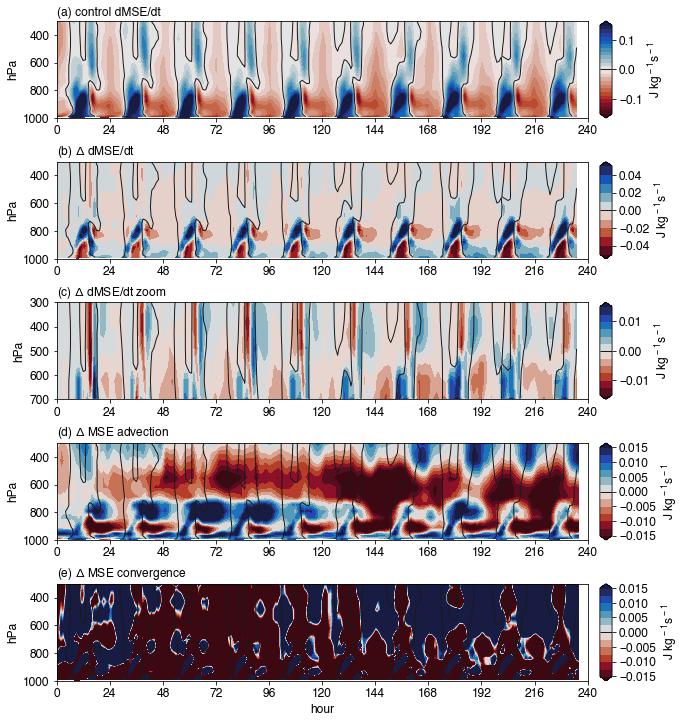

In [198]:
fontsize = 12

fig = mp.figure(figsize=(8.5,10))

##################################################
ax1 = fig.add_subplot(511)
ax1.tick_params(labelsize=fontsize)
levels = numpy.arange(-.15,.151,0.0125)
contour_plot1 = ax1.contourf(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                             dmsedt_400_dry_latlon_areamean.T, \
                             cmap=cmocean.cm.balance_r, extend='both', levels=levels)
contour_line1 = ax1.contour(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                            dmsedt_400_dry_latlon_areamean.T, \
                            levels=[0], linewidths=[1], colors='0.1')
ax1.set_ylim(1000,300)
ax1.set_xlim(0,240)
ax1.set_xticks([i for i in range(0,241,24)])
ax1.set_yticks([400,600,800,1000])
ax1.set_ylabel('hPa', fontsize=fontsize)


##################################################
ax2 = fig.add_subplot(512)
ax2.tick_params(labelsize=fontsize)
levels = numpy.arange(-0.05,0.051,0.01)
contour_plot2 = ax2.contourf(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                             dmsedt_diff_dry_latlon_areamean.T, \
                             cmap=cmocean.cm.balance_r, extend='both', levels=levels)
contour_line2 = ax2.contour(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                          dmsedt_400_dry_latlon_areamean.T, \
                          levels=[0], linewidths=[1], colors='0.1')
ax2.set_ylim(1000,300)
ax2.set_xlim(0,240)
ax2.set_ylabel('hPa', fontsize=fontsize)
ax2.set_xticks([i for i in range(0,241,24)])
ax2.set_yticks([400,600,800,1000])


##################################################
ax3 = fig.add_subplot(513)
ax3.tick_params(labelsize=fontsize)
levels = numpy.arange(-0.015,0.0151,0.0025)
contour_plot3 = ax3.contourf(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                             dmsedt_diff_dry_latlon_areamean.T, \
                             cmap=cmocean.cm.balance_r, levels=levels, extend='both')
contour_line3 = ax3.contour(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                          dmsedt_400_dry_latlon_areamean.T, \
                          levels=[0], linewidths=[1], colors='0.1')
ax3.set_ylim(700,300)
ax3.set_xlim(0,240)
#ax3.set_xlabel('hour', fontsize=fontsize)
ax3.set_ylabel('hPa', fontsize=fontsize)
ax3.set_xticks([i for i in range(0,241,24)])
ax3.set_yticks([300,400,500,600,700])


##################################################
ax4 = fig.add_subplot(514)
ax4.tick_params(labelsize=fontsize)
levels = numpy.arange(-0.015,0.0151,0.0025)
contour_plot4 = ax4.contourf(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                             advection_400_dry_latlon_areamean.T, \
                             levels=levels, \
                             cmap=cmocean.cm.balance_r, extend='both')
contour_line4 = ax4.contour(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                          dmsedt_400_dry_latlon_areamean.T, \
                          levels=[0], linewidths=[1], colors='0.1')
ax4.set_ylim(1000,300)
ax4.set_xlim(0,240)
#ax4.set_xlabel('hour', fontsize=fontsize)
ax4.set_ylabel('hPa', fontsize=fontsize)
ax4.set_xticks([i for i in range(0,241,24)])
ax4.set_yticks([400,600,800,1000])


##################################################
ax5 = fig.add_subplot(515)
ax5.tick_params(labelsize=fontsize)
levels = numpy.arange(-0.015,0.0151,0.0025)
contour_plot5 = ax5.contourf(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                             convergence_400_dry_latlon_areamean.T, \
                             levels=levels, \
                             cmap=cmocean.cm.balance_r, extend='both')
contour_line5 = ax5.contour(xx_dmsedt-4, ptot_400_dry_latlon_areamean.T/100., \
                          dmsedt_400_dry_latlon_areamean.T, \
                          levels=[0], linewidths=[1], colors='0.1')
ax5.set_ylim(1000,300)
ax5.set_xlim(0,240)
ax5.set_xlabel('hour', fontsize=fontsize)
ax5.set_ylabel('hPa', fontsize=fontsize)
ax5.set_xticks([i for i in range(0,241,24)])
ax5.set_yticks([400,600,800,1000])







ax1.text(s='(a) control dMSE/dt', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax1.transAxes)
ax2.text(s='(b) $\Delta$ dMSE/dt', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax2.transAxes)
ax3.text(s='(c) $\Delta$ dMSE/dt zoom', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax3.transAxes)
ax4.text(s='(d) $\Delta$ MSE advection', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax4.transAxes)
ax5.text(s='(e) $\Delta$ MSE convergence', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax5.transAxes)


fig.tight_layout(h_pad=2)

ax1pos = ax1.get_position()
cbar_ax1 = fig.add_axes([ax1pos.x1+0.02, ax1pos.y0, 0.02, ax1pos.height])
cbar1 = fig.colorbar(contour_plot1, cax=cbar_ax1)
cbar_ax1.tick_params(labelsize=fontsize)
cbar1.add_lines(contour_line1)
cbar1.set_label('J kg$^{\,-1}$s$^{\,-1}$', fontsize=fontsize)
cbar1.set_ticks([-.1,0,.1])

ax2pos = ax2.get_position()
cbar_ax2 = fig.add_axes([ax2pos.x1+0.02, ax2pos.y0, 0.02, ax2pos.height])
cbar2 = fig.colorbar(contour_plot2, cax=cbar_ax2)
cbar_ax2.tick_params(labelsize=fontsize)
cbar2.set_label('J kg$^{\,-1}$s$^{\,-1}$', fontsize=fontsize)
cbar2.add_lines(contour_line2)

ax3pos = ax3.get_position()
cbar_ax3 = fig.add_axes([ax3pos.x1+0.02, ax3pos.y0, 0.02, ax3pos.height])
cbar3 = fig.colorbar(contour_plot3, cax=cbar_ax3)
cbar_ax3.tick_params(labelsize=fontsize)
cbar3.add_lines(contour_line3)
cbar3.set_label('J kg$^{\,-1}$s$^{\,-1}$', fontsize=fontsize)
cbar3.set_ticks([-.01,0,.01])

ax4pos = ax4.get_position()
cbar_ax4 = fig.add_axes([ax4pos.x1+0.02, ax4pos.y0, 0.02, ax4pos.height])
cbar4 = fig.colorbar(contour_plot4, cax=cbar_ax4)
cbar_ax4.tick_params(labelsize=fontsize)
cbar4.add_lines(contour_line4)
cbar4.set_label('J kg$^{\,-1}$s$^{\,-1}$', fontsize=fontsize)
#cbar4.set_ticks([-.01,0,.01])

ax5pos = ax5.get_position()
cbar_ax5 = fig.add_axes([ax5pos.x1+0.02, ax5pos.y0, 0.02, ax5pos.height])
cbar5 = fig.colorbar(contour_plot5, cax=cbar_ax5)
cbar_ax5.tick_params(labelsize=fontsize)
cbar5.add_lines(contour_line5)
cbar5.set_label('J kg$^{\,-1}$s$^{\,-1}$', fontsize=fontsize)
#cbar5.set_ticks([-.01,0,.01])

fig.savefig('dmsedt_profile_first_10days_with_advection_convergence_terms.png', dpi=600, bbox_inches='tight', transparent=True)

# plot climatological moisture advection/convergence

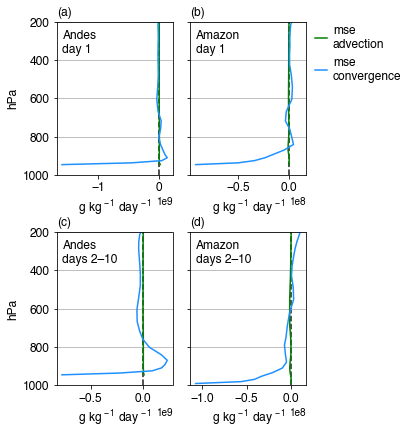

In [178]:
fontsize=12

fig = mp.figure(figsize=(4.5,6))

ax_list = []

#####
ax = fig.add_subplot(221)

ax.plot(advection_400_wet_region_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='green', label='moist. adv.')
ax.plot(convergence_400_wet_region_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='dodgerblue', label='moist. conv.')
ax.axvline(0, ls='--', c='0.1', zorder=1)
ax.set_ylim(1000,200)
#ax.set_xlim(-10,10)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Andes\nday 1', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(a)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

#####
ax = fig.add_subplot(222)

ax.plot(advection_400_dry_region_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='green', label='mse\nadvection')
ax.plot(convergence_400_dry_region_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='dodgerblue', label='mse\nconvergence')
ax.axvline(0, ls='--', c='0.1', zorder=1)
ax.set_ylim(1000,200)
#ax.set_xlim(-5,5)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_yticklabels([])
ax_list.append(ax)
ax.text(s='Amazon\nday 1', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(b)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()

#####
ax = fig.add_subplot(223)

ax.plot(advection_400_wet_region*1000.*86400.,ptot_400_wet_region_midpoints/100., c='green', label='mse\nadvection')
ax.plot(convergence_400_wet_region*1000.*86400.,ptot_400_wet_region_midpoints/100.,c='dodgerblue', label='mse\nconvergence')
ax.axvline(0, ls='--', c='0.1', zorder=1)
ax.set_ylim(1000,200)
#ax.set_xlim(-10,10)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Andes\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(c)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

#####
ax = fig.add_subplot(224)

ax.plot(advection_400_dry_region*1000.*86400.,ptot_400_dry_region_midpoints/100., c='green', label='mse\nadvection')
ax.plot(convergence_400_dry_region*1000.*86400.,ptot_400_dry_region_midpoints/100.,c='dodgerblue', label='mse\nconvergence')
ax.axvline(0, ls='--', c='0.1', zorder=1)
ax.set_ylim(1000,200)
#ax.set_xlim(-5,5)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_yticklabels([])
ax.text(s='Amazon\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(d)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

fig.tight_layout(h_pad=1)

handles, labels = ax_list[1].get_legend_handles_labels()
legend = ax_list[1].legend(handles, labels, fontsize=fontsize, bbox_to_anchor=(1.05,1), edgecolor='None', \
                   facecolor='None', fancybox=False, bbox_transform=ax_list[1].transAxes, loc='upper left', \
                   borderaxespad=0., borderpad=0.25, handlelength=1.0, handletextpad=0.5, \
                   columnspacing=0.5, markerscale=1)

fig.savefig('manuscript_figXX_climatological_mse_budget_TOTAL_10d_and_day1.png', dpi=600, \
            transparent=True, bbox_inches='tight')


# plot individual conv, div, dmsedt terms

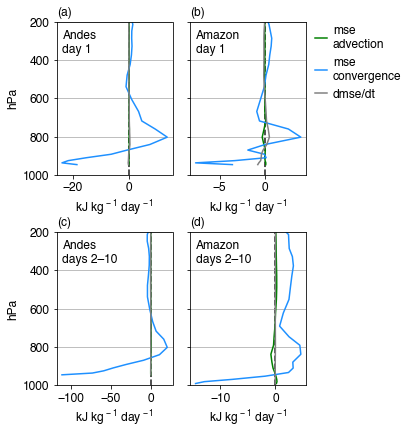

In [85]:
fontsize=12

fig = mp.figure(figsize=(4.5,6))

ax_list = []

#####
ax = fig.add_subplot(221)

ax.plot(diff_wet_region_adv_day1*86400./1000.,ptot_400_wet_region_midpoints/100., c='green', label='moist. adv.')
ax.plot(diff_wet_region_conv_day1*86400./1000.,ptot_400_wet_region_midpoints/100., c='dodgerblue', label='moist. conv.')
ax.plot(diff_wet_region_dmsedt_day1*86400./1000.,ptot_400_wet_region_midpoints/100., c='0.5', label='dmse/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
ax.set_ylim(1000,200)
#ax.set_xlim(-1.5,1)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('kJ kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Andes\nday 1', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(a)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

#####
ax = fig.add_subplot(222)

ax.plot(diff_dry_region_adv_day1*86400./1000.,ptot_400_wet_region_midpoints/100., c='green', label='mse\nadvection')
ax.plot(diff_dry_region_conv_day1*86400./1000.,ptot_400_wet_region_midpoints/100., c='dodgerblue', label='mse\nconvergence')
ax.plot(diff_dry_region_dmsedt_day1*86400./1000.,ptot_400_wet_region_midpoints/100., c='0.5', label='dmse/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
ax.set_ylim(1000,200)
#ax.set_xlim(-0.75,0.5)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('kJ kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_yticklabels([])
ax_list.append(ax)
ax.text(s='Amazon\nday 1', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(b)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()

#####
ax = fig.add_subplot(223)

ax.plot(diff_wet_region_adv*86400./1000.,ptot_400_wet_region_midpoints/100., c='green', label='mse\nadvection')
ax.plot(diff_wet_region_conv*86400./1000.,ptot_400_wet_region_midpoints/100.,c='dodgerblue', label='mse\nconvergence')
ax.plot(diff_wet_region_dmsedt*86400./1000.,ptot_400_wet_region_midpoints/100.,c='0.5', label='dmse/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
ax.set_ylim(1000,200)
#ax.set_xlim(-1.5,1)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('kJ kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Andes\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(c)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

#####
ax = fig.add_subplot(224)

ax.plot(diff_dry_region_adv*86400./1000.,ptot_400_dry_region_midpoints/100., c='green', label='mse\nadvection')
ax.plot(diff_dry_region_conv*86400./1000.,ptot_400_dry_region_midpoints/100.,c='dodgerblue', label='mse\nconvergence')
ax.plot(diff_dry_region_dmsedt*86400./1000.,ptot_400_dry_region_midpoints/100.,c='0.5',label='dmse/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
ax.set_ylim(1000,200)
#ax.set_xlim(-0.75,0.5)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('kJ kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_yticklabels([])
ax.text(s='Amazon\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(d)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

fig.tight_layout(h_pad=1)

handles, labels = ax_list[1].get_legend_handles_labels()
legend = ax_list[1].legend(handles, labels, fontsize=fontsize, bbox_to_anchor=(1.05,1), edgecolor='None', \
                   facecolor='None', fancybox=False, bbox_transform=ax_list[1].transAxes, loc='upper left', \
                   borderaxespad=0., borderpad=0.25, handlelength=1.0, handletextpad=0.5, \
                   columnspacing=0.5, markerscale=1)

fig.savefig('manuscript_figXX_mean_mse_budget_TOTAL_10d_and_day1.png', dpi=600, \
            transparent=True, bbox_inches='tight')

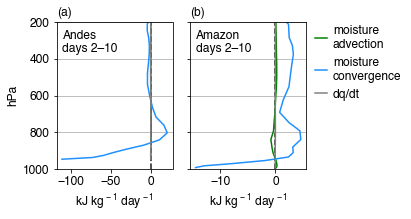

In [86]:
fontsize=12

fig = mp.figure(figsize=(4.5,3))

ax_list = []

#####
ax = fig.add_subplot(121)

ax.plot(diff_wet_region_adv*86400./1000.,ptot_400_wet_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_wet_region_conv*86400./1000.,ptot_400_wet_region_midpoints/100.,c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_wet_region_dmsedt*86400./1000.,ptot_400_wet_region_midpoints/100.,c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
ax.set_ylim(1000,200)
#ax.set_xlim(-1.5,1)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('kJ kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Andes\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(a)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

#####
ax = fig.add_subplot(122)

ax.plot(diff_dry_region_adv*86400./1000.,ptot_400_dry_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_dry_region_conv*86400./1000.,ptot_400_dry_region_midpoints/100.,c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_dry_region_dmsedt*86400./1000.,ptot_400_dry_region_midpoints/100.,c='0.5',label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
ax.set_ylim(1000,200)
#ax.set_xlim(-0.75,0.5)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('kJ kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_yticklabels([])
ax.text(s='Amazon\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(b)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

fig.tight_layout(h_pad=1)

handles, labels = ax_list[1].get_legend_handles_labels()
legend = ax_list[1].legend(handles, labels, fontsize=fontsize, bbox_to_anchor=(1.05,1), edgecolor='None', \
                   facecolor='None', fancybox=False, bbox_transform=ax_list[1].transAxes, loc='upper left', \
                   borderaxespad=0., borderpad=0.25, handlelength=1.0, handletextpad=0.5, \
                   columnspacing=0.5, markerscale=1)

fig.savefig('manuscript_figXX_mean_mse_budget_TOTAL_10d_ONLY.png', dpi=600, \
            transparent=True, bbox_inches='tight')

# Do same for vertical terms

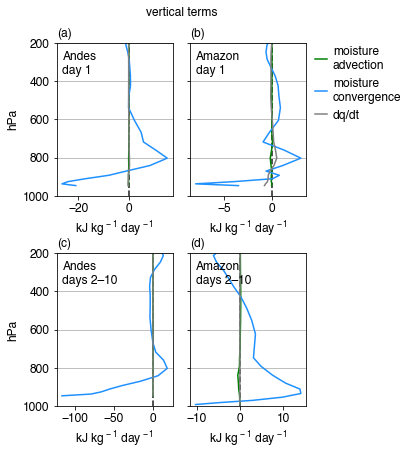

In [87]:
fontsize=12

fig = mp.figure(figsize=(4.5,6))

ax_list = []

#####
ax = fig.add_subplot(221)

ax.plot(diff_wet_region_vert_adv_day1*86400./1000.,ptot_400_wet_region_midpoints/100., c='green', label='moist. adv.')
ax.plot(diff_wet_region_vert_conv_day1*86400./1000.,ptot_400_wet_region_midpoints/100., c='dodgerblue', label='moist. conv.')
ax.plot(diff_wet_region_dmsedt_day1*86400./1000.,ptot_400_wet_region_midpoints/100., c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
ax.set_ylim(1000,200)
#ax.set_xlim(-1.5,1)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('kJ kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Andes\nday 1', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(a)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

#####
ax = fig.add_subplot(222)

ax.plot(diff_dry_region_vert_adv_day1*86400./1000.,ptot_400_wet_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_dry_region_vert_conv_day1*86400./1000.,ptot_400_wet_region_midpoints/100., c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_dry_region_dmsedt_day1*86400./1000.,ptot_400_wet_region_midpoints/100., c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
ax.set_ylim(1000,200)
#ax.set_xlim(-0.75,0.5)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('kJ kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_yticklabels([])
ax_list.append(ax)
ax.text(s='Amazon\nday 1', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(b)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()

#####
ax = fig.add_subplot(223)

ax.plot(diff_wet_region_vert_adv*86400./1000.,ptot_400_wet_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_wet_region_vert_conv*86400./1000.,ptot_400_wet_region_midpoints/100.,c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_wet_region_dmsedt*86400./1000.,ptot_400_wet_region_midpoints/100.,c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
ax.set_ylim(1000,200)
#ax.set_xlim(-1.5,1)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('kJ kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Andes\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(c)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

#####
ax = fig.add_subplot(224)

ax.plot(diff_dry_region_vert_adv*86400./1000.,ptot_400_dry_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_dry_region_vert_conv*86400./1000.,ptot_400_dry_region_midpoints/100.,c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_dry_region_dmsedt*86400./1000.,ptot_400_dry_region_midpoints/100.,c='0.5',label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
ax.set_ylim(1000,200)
#ax.set_xlim(-0.75,0.5)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('kJ kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_yticklabels([])
ax.text(s='Amazon\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(d)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

fig.tight_layout(h_pad=1)

handles, labels = ax_list[1].get_legend_handles_labels()
legend = ax_list[1].legend(handles, labels, fontsize=fontsize, bbox_to_anchor=(1.05,1), edgecolor='None', \
                   facecolor='None', fancybox=False, bbox_transform=ax_list[1].transAxes, loc='upper left', \
                   borderaxespad=0., borderpad=0.25, handlelength=1.0, handletextpad=0.5, \
                   columnspacing=0.5, markerscale=1)

axpos1 = ax_list[0].get_position()
axpos2 = ax_list[1].get_position()

fig.text(s='vertical terms', x=0.5*(axpos1.x0+axpos2.x1), y=1.02, transform=fig.transFigure, ha='center', va='bottom', fontsize=fontsize)

fig.savefig('manuscript_figXX_mean_mse_budget_VERTICAL_10d_and_day1.png', dpi=600, \
            transparent=True, bbox_inches='tight')

# horizontal terms

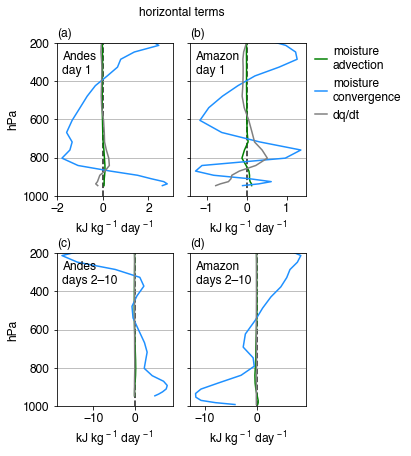

In [123]:
fontsize=12

fig = mp.figure(figsize=(4.5,6))

ax_list = []

#####
ax = fig.add_subplot(221)

ax.plot(diff_wet_region_horiz_adv_day1*86400./1000.,ptot_400_wet_region_midpoints/100., c='green', label='moist. adv.')
ax.plot(diff_wet_region_horiz_conv_day1*86400./1000.,ptot_400_wet_region_midpoints/100., c='dodgerblue', label='moist. conv.')
ax.plot(diff_wet_region_dmsedt_day1*86400./1000.,ptot_400_wet_region_midpoints/100., c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
ax.set_ylim(1000,200)
#ax.set_xlim(-1.5,1)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('kJ kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Andes\nday 1', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(a)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

#####
ax = fig.add_subplot(222)

ax.plot(diff_dry_region_horiz_adv_day1*86400./1000.,ptot_400_wet_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_dry_region_horiz_conv_day1*86400./1000.,ptot_400_wet_region_midpoints/100., c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_dry_region_dmsedt_day1*86400./1000.,ptot_400_wet_region_midpoints/100., c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
ax.set_ylim(1000,200)
#ax.set_xlim(-0.75,0.5)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('kJ kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_yticklabels([])
ax_list.append(ax)
ax.text(s='Amazon\nday 1', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(b)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()

#####
ax = fig.add_subplot(223)

ax.plot(diff_wet_region_horiz_adv*86400./1000.,ptot_400_wet_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_wet_region_horiz_conv*86400./1000.,ptot_400_wet_region_midpoints/100.,c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_wet_region_dmsedt*86400./1000.,ptot_400_wet_region_midpoints/100.,c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
ax.set_ylim(1000,200)
#ax.set_xlim(-1.5,1)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('kJ kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Andes\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(c)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

#####
ax = fig.add_subplot(224)

ax.plot(diff_dry_region_horiz_adv*86400./1000.,ptot_400_dry_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_dry_region_horiz_conv*86400./1000.,ptot_400_dry_region_midpoints/100.,c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_dry_region_dmsedt*86400./1000.,ptot_400_dry_region_midpoints/100.,c='0.5',label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
ax.set_ylim(1000,200)
#ax.set_xlim(-0.75,0.5)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('kJ kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_yticklabels([])
ax.text(s='Amazon\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(d)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

fig.tight_layout(h_pad=1)

handles, labels = ax_list[1].get_legend_handles_labels()
legend = ax_list[1].legend(handles, labels, fontsize=fontsize, bbox_to_anchor=(1.05,1), edgecolor='None', \
                   facecolor='None', fancybox=False, bbox_transform=ax_list[1].transAxes, loc='upper left', \
                   borderaxespad=0., borderpad=0.25, handlelength=1.0, handletextpad=0.5, \
                   columnspacing=0.5, markerscale=1)

axpos1 = ax_list[0].get_position()
axpos2 = ax_list[1].get_position()

fig.text(s='horizontal terms', x=0.5*(axpos1.x0+axpos2.x1), y=1.02, transform=fig.transFigure, ha='center', va='bottom', fontsize=fontsize)

fig.savefig('manuscript_figXX_mean_mse_budget_HORIZONTAL_10d_and_day1.png', dpi=600, \
            transparent=True, bbox_inches='tight')

# lat subsets and latmeans

In [125]:
ptot_400_midpoints_lat_subset = ptot_400_midpoints[:,:,lat_indices_midpoints[:,0],:]
ptot_1000_midpoints_lat_subset = ptot_1000_midpoints[:,:,lat_indices_midpoints[:,0],:]

In [126]:
ptot_400_lat_subset = ptot_400[:,:,lat_indices[:,0],:]
ptot_1000_lat_subset = ptot_1000[:,:,lat_indices[:,0],:]

In [127]:
advection_400_lat_subset = advection_400[:,:,lat_indices_midpoints[:,0],:]
advection_1000_lat_subset = advection_1000[:,:,lat_indices_midpoints[:,0],:]

convergence_400_lat_subset = convergence_400[:,:,lat_indices_midpoints[:,0],:]
convergence_1000_lat_subset = convergence_1000[:,:,lat_indices_midpoints[:,0],:]

In [128]:
cont_adv_latmean = numpy.nanmean(advection_400_lat_subset, axis=2)
phys_adv_latmean = numpy.nanmean(advection_1000_lat_subset, axis=2)

cont_conv_latmean = numpy.nanmean(convergence_400_lat_subset, axis=2)
phys_conv_latmean = numpy.nanmean(convergence_1000_lat_subset, axis=2)

In [129]:
dmsedt_400_lat_subset = dmsedt_400[:,:,lat_indices_midpoints[:,0],:]
dmsedt_1000_lat_subset = dmsedt_1000[:,:,lat_indices_midpoints[:,0],:]

In [132]:
ptot_400_latmean = numpy.nanmean(ptot_400_lat_subset, axis=2)
ptot_1000_latmean = numpy.nanmean(ptot_1000_lat_subset, axis=2)

In [133]:
ptot_400_midpoints_latmean = numpy.nanmean(ptot_400_midpoints_lat_subset, axis=2)
ptot_1000_midpoints_latmean = numpy.nanmean(ptot_1000_midpoints_lat_subset, axis=2)

In [134]:
dmsedt_400_latmean = numpy.nanmean(dmsedt_400_lat_subset, axis=2)
dmsedt_1000_latmean = numpy.nanmean(dmsedt_1000_lat_subset, axis=2)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [135]:
ptot_400_midpoints_lat_subset = ptot_400_midpoints[:,:,lat_indices_midpoints[:,0],:]
ptot_400_midpoints_latmean = numpy.nanmean(ptot_400_midpoints_lat_subset, axis=2)

In [136]:
xx,zz=numpy.meshgrid(xlong[0,:],ptot_400[0,:,:,0].mean(axis=1))

In [137]:
diff_adv_latmean = phys_adv_latmean-cont_adv_latmean
diff_conv_latmean = phys_conv_latmean-cont_conv_latmean
diff_dmsedt_latmean = dmsedt_1000_latmean-dmsedt_400_latmean

In [138]:
wa_diffs_lat_subset = wa_diffs_landmask[:,:,lat_indices[:,0],:]
wa_diffs_latmean = numpy.nanmean(wa_diffs_lat_subset, axis=2)
wa_diffs_time_latmean = numpy.nanmean(wa_diffs_latmean[24:,:,:], axis=0)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [139]:
ptot_400_time_latmean = numpy.nanmean(ptot_400_latmean, axis=0)

# gridspec version of plot

# Plot dmsedt and moisture convergence in lat means

In [140]:
dmsedt_diff_latmean = dmsedt_1000_latmean - dmsedt_400_latmean

In [141]:
xx_midpoints = 0.5*(xx[1:,1:]+xx[:-1,:-1])

ptot_400_time_latmean_midpoints = 0.5*(ptot_400_time_latmean[1:,1:]+\
                                       ptot_400_time_latmean[:-1,:-1])

# dmsedt and convergence terms on day 1

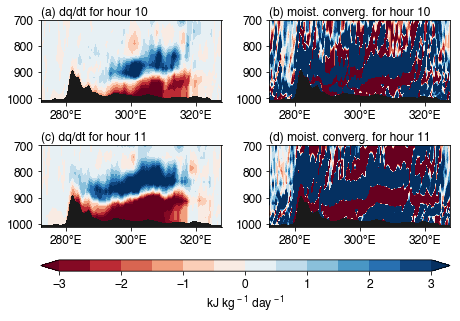

In [143]:
fontsize=12

xlong_min = -154.76123
xlong_max = -25.238678

levels = numpy.arange(-3,3.1,0.5)

fig = mp.figure(figsize=(6.5,3.5))

xticks_deg_E=numpy.array((280,300,320))
xticks = -(360-xticks_deg_E)
xticks_format=[str(tick)+DEGREE_SIGN+'E' for tick in xticks_deg_E]

ax_list = []

hour1 = 13
hour1_string = hour1-4+1

hour2 = 14
hour2_string = hour2-4+1

ax = fig.add_subplot(221)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           dmsedt_diff_latmean[hour1,:,:]*86400./1000., cmap='RdBu',\
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(a) dq/dt for hour '+'{:02d}'.format(hour1_string), x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax_list.append(ax)

ax = fig.add_subplot(222)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           diff_conv_latmean[hour1,:,:]*86400./1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(b) moist. converg. for hour '+'{:02d}'.format(hour1_string), x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax_list.append(ax)

ax = fig.add_subplot(223)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           dmsedt_diff_latmean[hour2,:,:]*86400./1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(c) dq/dt for hour '+'{:02d}'.format(hour2_string), x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax_list.append(ax)

ax = fig.add_subplot(224)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           diff_conv_latmean[hour2,:,:]*86400./1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(d) moist. converg. for hour '+'{:02d}'.format(hour2_string), x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax_list.append(ax)

fig.tight_layout(h_pad=2)

axpos_bl = ax_list[2].get_position()
axpos_br = ax_list[3].get_position()

cbar_ax = fig.add_axes([axpos_bl.x0, axpos_bl.y0-0.175, axpos_br.x1-axpos_bl.x0, 0.045])
cbar = fig.colorbar(contour_plot, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('kJ kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)

fig.savefig('dmsedt_and_mse_convergence_hours_'+\
            '{:02d}'.format(hour1_string)+\
            'and'+'{:02d}'.format(hour2_string)+'.png',\
            dpi=600, bbox_inches='tight')

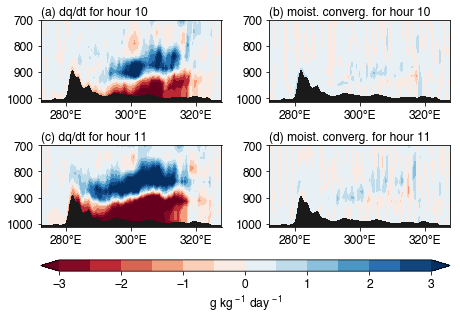

In [144]:
fontsize=12

xlong_min = -154.76123
xlong_max = -25.238678

levels = numpy.arange(-3,3.1,0.5)

fig = mp.figure(figsize=(6.5,3.5))

xticks_deg_E=numpy.array((280,300,320))
xticks = -(360-xticks_deg_E)
xticks_format=[str(tick)+DEGREE_SIGN+'E' for tick in xticks_deg_E]

ax_list = []

hour1 = 13
hour1_string = hour1-4+1

hour2 = 14
hour2_string = hour2-4+1

ax = fig.add_subplot(221)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           dmsedt_diff_latmean[hour1,:,:]*86400./1000., cmap='RdBu',\
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(a) dq/dt for hour '+'{:02d}'.format(hour1_string), x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax_list.append(ax)

ax = fig.add_subplot(222)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           diff_adv_latmean[hour1,:,:]*86400./1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(b) moist. converg. for hour '+'{:02d}'.format(hour1_string), x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax_list.append(ax)

ax = fig.add_subplot(223)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           dmsedt_diff_latmean[hour2,:,:]*86400./1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(c) dq/dt for hour '+'{:02d}'.format(hour2_string), x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax_list.append(ax)

ax = fig.add_subplot(224)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           diff_adv_latmean[hour2,:,:]*86400./1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(d) moist. converg. for hour '+'{:02d}'.format(hour2_string), x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax_list.append(ax)

fig.tight_layout(h_pad=2)

axpos_bl = ax_list[2].get_position()
axpos_br = ax_list[3].get_position()

cbar_ax = fig.add_axes([axpos_bl.x0, axpos_bl.y0-0.175, axpos_br.x1-axpos_bl.x0, 0.045])
cbar = fig.colorbar(contour_plot, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)

fig.savefig('dmsedt_and_mse_advection_hours_'+\
            '{:02d}'.format(hour1_string)+\
            'and'+'{:02d}'.format(hour2_string)+'.png',\
            dpi=600, bbox_inches='tight')

In [1]:
fontsize=12

xlong_min = -154.76123
xlong_max = -25.238678

levels = numpy.arange(-10,10.1,2)

fig = mp.figure(figsize=(8,3.5))

xticks_deg_E=numpy.array((280,300,320))
xticks = -(360-xticks_deg_E)
xticks_format=[str(tick)+DEGREE_SIGN+'E' for tick in xticks_deg_E]

ax_list = []

hour1 = 13
hour1_string = hour1-4+1

hour2 = 14
hour2_string = hour2-4+1

ax = fig.add_subplot(231)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           dmsedt_diff_latmean[hour1,:,:]*86400./1000., cmap='RdBu',\
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(a) dq/dt', x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax.text(s='hour '+'{:02d}'.format(hour1_string), x=0.95, y=0.91, \
        ha='right', va='top', \
        transform=ax.transAxes, fontsize=fontsize)
ax_list.append(ax)

ax = fig.add_subplot(232)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           diff_conv_latmean[hour1,:,:]*86400./1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(b) moisture convergence', x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax.text(s='hour '+'{:02d}'.format(hour1_string), x=0.95, y=0.91, \
        ha='right', va='top', \
        transform=ax.transAxes, fontsize=fontsize)
ax_list.append(ax)



ax = fig.add_subplot(233)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           diff_adv_latmean[hour1,:,:]*86400./1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(c) moisture advection', x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax.text(s='hour '+'{:02d}'.format(hour1_string), x=0.95, y=0.91, \
        ha='right', va='top', \
        transform=ax.transAxes, fontsize=fontsize)
ax_list.append(ax)





ax = fig.add_subplot(234)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           dmsedt_diff_latmean[hour2,:,:]*86400./1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(d) dq/dt', x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax.text(s='hour '+'{:02d}'.format(hour2_string), x=0.95, y=0.91, \
        ha='right', va='top', \
        transform=ax.transAxes, fontsize=fontsize)
ax_list.append(ax)


ax = fig.add_subplot(235)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           diff_conv_latmean[hour2,:,:]*86400./1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(e) moisture convergence', x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax.text(s='hour '+'{:02d}'.format(hour2_string), x=0.95, y=0.91, \
        ha='right', va='top', \
        transform=ax.transAxes, fontsize=fontsize)
ax_list.append(ax)


ax = fig.add_subplot(236)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           diff_adv_latmean[hour2,:,:]*86400./1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(f) moisture advection', x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax.text(s='hour '+'{:02d}'.format(hour2_string), x=0.95, y=0.91, \
        ha='right', va='top', \
        transform=ax.transAxes, fontsize=fontsize)
ax_list.append(ax)


fig.tight_layout(h_pad=2)

axpos_bl = ax_list[3].get_position()
axpos_br = ax_list[5].get_position()

cbar_ax = fig.add_axes([axpos_bl.x0, axpos_bl.y0-0.175, axpos_br.x1-axpos_bl.x0, 0.045])
cbar = fig.colorbar(contour_plot, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)

fig.savefig('dmsedt_and_mse_convergence_and_advection_hours_'+\
            '{:02d}'.format(hour1_string)+\
            'and'+'{:02d}'.format(hour2_string)+'.png',\
            dpi=600, bbox_inches='tight')

NameError: name 'numpy' is not defined